In [9]:
pip install ortools pymoo matplotlib numpy shapely deap

  Obtaining dependency information for deap from https://files.pythonhosted.org/packages/6d/89/48a1f7b94a754d91634183c5a88b76a461620dc9c3fceb0abb3b6badbc3b/deap-1.4.3-cp311-cp311-macosx_10_9_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 kB 1.8 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. Đang chạy tối ưu Global (NSGA-II)...
-> Kết quả tối ưu: Spacing=25.34m, Angle=87.18 độ
2. Đang render animation...


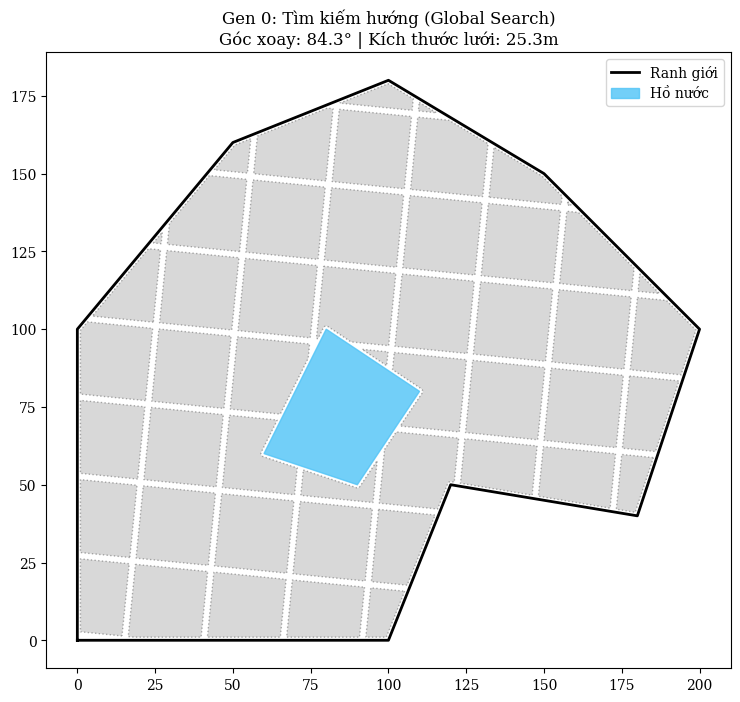

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.affinity import rotate, translate
from deap import base, creator, tools, algorithms

# ==========================================
# 1. SETUP DỮ LIỆU ĐỊA LÝ (GEOMETRY SETUP)
# ==========================================

# Giả lập khu đất phức tạp (Polygon không lồi)
LAND_COORDS = [
    (0, 0), (100, 0), (120, 50), (180, 40), (200, 100), 
    (150, 150), (100, 180), (50, 160), (0, 100)
]
LAND_POLY = Polygon(LAND_COORDS)

# Giả lập Hồ nước (Vật cản) nằm giữa đất
LAKE_COORDS = [
    (60, 60), (90, 50), (110, 80), (80, 100)
]
LAKE_POLY = Polygon(LAKE_COORDS)

# ==========================================
# 2. CORE ALGORITHM: HÌNH HỌC & LƯỚI
# ==========================================

def generate_grid_candidates(spacing, angle_deg, shrink_for_roads=2.0):
    """
    Tạo lưới Block, xoay theo góc, và lọc sơ bộ.
    shrink_for_roads: Thu nhỏ block để tạo khoảng hở làm đường.
    """
    # Tạo bao (bounds) lớn hơn đất để lưới phủ kín
    minx, miny, maxx, maxy = LAND_POLY.bounds
    diameter = ((maxx-minx)**2 + (maxy-miny)**2)**0.5
    center = LAND_POLY.centroid
    
    # Tạo lưới điểm gốc
    x_range = np.arange(minx - diameter, maxx + diameter, spacing)
    y_range = np.arange(miny - diameter, maxy + diameter, spacing)
    
    blocks = []
    
    # Xoay lưới bằng cách xoay từng block (hoặc xoay đất ngược lại, ở đây ta xoay block)
    # Tuy nhiên cách nhanh hơn: Tạo lưới thẳng -> Xoay Polygon Lưới -> Cắt
    
    # Tạo 1 block mẫu ở tâm 0,0
    base_block = Polygon([(0, 0), (spacing, 0), (spacing, spacing), (0, spacing)])
    # Dời về tâm để xoay
    base_block = translate(base_block, -spacing/2, -spacing/2)
    
    for x in x_range:
        for y in y_range:
            # Tạo block tại vị trí
            poly = translate(base_block, x, y)
            # Xoay quanh tâm đất chính
            poly = rotate(poly, angle_deg, origin=center)
            
            # Chỉ lấy những block có dính dáng tới khu đất (tăng tốc độ)
            if poly.intersects(LAND_POLY):
                blocks.append(poly)
                
    return blocks

def evaluate_layout(individual):
    """
    Hàm mục tiêu cho NSGA-II.
    Ind: [spacing, angle]
    
    Mục tiêu 1 (Maximize): Diện tích đất ở (Residential Area)
    Mục tiêu 2 (Minimize): Số lượng block bị cắt vụn (Fragmentation)
    """
    spacing, angle = individual
    blocks = generate_grid_candidates(spacing, angle)
    
    total_residential_area = 0
    fragmented_blocks = 0
    
    for blk in blocks:
        # 1. Cắt với biên đất
        intersection = blk.intersection(LAND_POLY)
        if intersection.is_empty:
            continue
            
        # 2. Trừ đi hồ nước
        usable_part = intersection.difference(LAKE_POLY)
        
        if usable_part.is_empty:
            continue
            
        # Tính tỷ lệ diện tích hữu dụng so với block nguyên bản
        original_area = spacing * spacing
        actual_area = usable_part.area
        ratio = actual_area / original_area
        
        # LOGIC QUY HOẠCH:
        # - Nếu tỷ lệ > 0.6: Đất đẹp -> Làm nhà ở
        # - Nếu 0.1 < tỷ lệ < 0.6: Đất méo/bị hồ cắt -> Phạt (coi là bad fitness) hoặc tính là công viên
        # - Nếu tỷ lệ < 0.1: Quá nhỏ -> Bỏ qua
        
        if ratio > 0.65:
            total_residential_area += actual_area
        elif ratio > 0.1:
            fragmented_blocks += 1 # Càng nhiều block vụn càng tệ
            
    return (total_residential_area, fragmented_blocks)

# ==========================================
# 3. GLOBAL OPTIMIZATION: NSGA-II (DEAP)
# ==========================================

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0)) # Max Area, Min Fragments
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
# Gene 1: Kích thước block (20m - 40m)
toolbox.register("attr_spacing", random.uniform, 20, 40)
# Gene 2: Góc xoay (0 - 90 độ)
toolbox.register("attr_angle", random.uniform, 0, 90)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_spacing, toolbox.attr_angle), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_layout)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=[20, 0], up=[40, 90], eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[20, 0], up=[40, 90], eta=20.0, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

def run_nsga2_with_history():
    """Chạy NSGA-II và lưu lại 'Best Individual' mỗi thế hệ để làm Animation"""
    random.seed(42)
    pop = toolbox.population(n=30)
    NGEN = 15 # Số thế hệ (giảm xuống để demo nhanh)
    
    history = []
    
    # Gen 0
    fits = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fits):
        ind.fitness.values = fit
    
    # Lưu thằng tốt nhất Gen 0
    best_ind = tools.selBest(pop, 1)[0]
    history.append(list(best_ind)) # Clone data
    
    for gen in range(NGEN):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)
        fits = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        pop = toolbox.select(pop + offspring, k=len(pop))
        
        # Lưu thằng tốt nhất mỗi Gen
        best_ind = tools.selBest(pop, 1)[0]
        history.append(list(best_ind))
        
    return pop, history

# ==========================================
# 4. LOCAL OPTIMIZATION: CHI TIẾT HÓA (Mô phỏng MILP)
# ==========================================

def detailed_subdivision(geom, spacing):
    """
    Chia nhỏ block thành lô đất (Lots).
    Xử lý logic: Block méo -> Công viên. Block đẹp -> Nhà ở.
    """
    # Logic xác định loại đất
    original_area = spacing * spacing
    current_area = geom.area
    ratio = current_area / original_area
    
    result = {'geometry': geom, 'type': 'unknown', 'subdivisions': []}
    
    # FIX: Rìa méo hoặc bị hồ lấn -> Làm công viên cây xanh
    if ratio < 0.6: 
        result['type'] = 'park'
        return result
    
    # Block đẹp -> Làm nhà ở (Residential)
    result['type'] = 'residential'
    
    # Chia lô đơn giản (Giả lập MILP cắt dọc)
    # Tìm bounding box cục bộ
    minx, miny, maxx, maxy = geom.bounds
    lot_width = 5 # Giả sử mặt tiền 5m
    
    # Tạo các vạch cắt song song
    num_cuts = int((maxx - minx) / lot_width)
    
    # Lưu ý: Ở đây ta chỉ vẽ tượng trưng các đường cắt
    # Trong thực tế cần dùng shapely để cắt polygon thật
    cuts = []
    for i in range(1, num_cuts):
        x_cut = minx + i * lot_width
        cuts.append(x_cut)
    
    result['subdivisions'] = cuts # Danh sách các đường x local
    return result

# ==========================================
# 5. VISUALIZATION & ANIMATION
# ==========================================

def run_full_demo():
    print("1. Đang chạy tối ưu Global (NSGA-II)...")
    final_pop, history = run_nsga2_with_history()
    
    # Lấy kết quả tốt nhất cuối cùng
    best_final = tools.selBest(final_pop, 1)[0]
    print(f"-> Kết quả tối ưu: Spacing={best_final[0]:.2f}m, Angle={best_final[1]:.2f} độ")

    # --- SETUP PLOT ---
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def update(frame_idx):
        ax.clear()
        
        # Nếu là frame cuối cùng -> Hiển thị chế độ quy hoạch chi tiết (Final)
        is_final_frame = (frame_idx == len(history) - 1)
        
        current_dna = history[frame_idx]
        spacing, angle = current_dna
        
        # Vẽ Đất & Hồ nền
        x_land, y_land = LAND_POLY.exterior.xy
        ax.plot(x_land, y_land, 'k-', linewidth=2, label='Ranh giới')
        x_lake, y_lake = LAKE_POLY.exterior.xy
        ax.fill(x_lake, y_lake, color='#4fc3f7', alpha=0.8, label='Hồ nước')
        
        # Sinh lưới thô
        raw_blocks = generate_grid_candidates(spacing, angle)
        
        # Xử lý từng block
        for raw_blk in raw_blocks:
            # Intersection thực tế
            inter = raw_blk.intersection(LAND_POLY).difference(LAKE_POLY)
            
            if inter.is_empty:
                continue
                
            # Xử lý MultiPolygon (nếu bị hồ cắt đôi)
            geoms = [inter] if inter.geom_type != 'MultiPolygon' else list(inter.geoms)
            
            for part in geoms:
                # Tạo khoảng hở (Road Connectivity) bằng buffer âm
                # Chỉ áp dụng buffer nếu miếng đất đủ lớn, nếu nhỏ quá buffer sẽ biến mất
                buffered_part = part.buffer(-1.0) # Thu vào 1m mỗi bên -> Đường rộng 2m
                
                if buffered_part.is_empty:
                    continue # Mất luôn -> Bỏ
                
                if is_final_frame:
                    # --- LOCAL OPTIMIZATION VIEW ---
                    detail = detailed_subdivision(buffered_part, spacing)
                    
                    if detail['type'] == 'park':
                        # Vẽ màu xanh lá
                        x, y = buffered_part.exterior.xy
                        ax.fill(x, y, color='#66bb6a', alpha=0.7, edgecolor='None')
                    else:
                        # Vẽ màu cam (Nhà ở)
                        x, y = buffered_part.exterior.xy
                        ax.fill(x, y, color='#ffcc80', alpha=0.9, edgecolor='black', linewidth=0.5)
                        
                        # Vẽ các đường chia lô (Subdivision)
                        # (Mô phỏng visual: vẽ các line song song bên trong block)
                        # Để đơn giản hoá visual xoay, ta chỉ tô màu block
                else:
                    # --- SEARCHING VIEW (Màu xám nhạt) ---
                    x, y = buffered_part.exterior.xy
                    ax.fill(x, y, color='gray', alpha=0.3, edgecolor='black', linestyle=':')

        step_name = "Tối ưu cục bộ (Chia lô)" if is_final_frame else "Tìm kiếm hướng (Global Search)"
        ax.set_title(f"Gen {frame_idx}: {step_name}\nGóc xoay: {angle:.1f}° | Kích thước lưới: {spacing:.1f}m")
        ax.set_aspect('equal')
        
        if frame_idx == 0:
            ax.legend(loc='upper right')

    # Tạo Animation
    # Lặp lại frame cuối 10 lần để người xem kịp nhìn kết quả
    anim_frames = list(range(len(history))) + [len(history)-1]*10
    
    anim = FuncAnimation(fig, update, frames=anim_frames, interval=500, repeat=True)
    
    print("2. Đang render animation...")
    
    # Trong Jupyter Notebook, dùng dòng này để hiện video:
    from IPython.display import HTML
    return HTML(anim.to_jshtml())

# Chạy
if __name__ == "__main__":
    # Lưu ý: Kết quả trả về là một HTML object (trong Notebook)
    # Nếu chạy script thường, dùng plt.show() ở cuối hàm run_full_demo thay vì return HTML
    res = run_full_demo()
    # plt.show() # Bật dòng này nếu chạy file .py
    display(res) # Bật dòng này nếu chạy Jupyter

In [8]:
pip install deap shapely matplotlib ortools scipy numpy


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# ==========================================
# 1. CẤU HÌNH TOÀN CỤC (CONFIG)
# ==========================================
import math

# --- A. Cấu hình Dữ liệu Đất & Vật cản ---
# Tọa độ ranh giới khu đất (Polygon bao ngoài)
LAND_COORDS = [
    (0, 0), (200, 0), (220, 150), (100, 200), (-50, 150), (-20, 50)
]

# Tọa độ các vật cản (Hồ nước, núi đá, công trình cũ...)
# List các Polygon. Thuật toán sẽ KHÔNG chia lô vào các vùng này.
OBSTACLES_COORDS = [
    [(50, 50), (100, 50), (100, 100), (60, 90)], # Vật cản 1 (ví dụ: Hồ nước giữa đất)
    [(150, 20), (180, 20), (170, 60)]            # Vật cản 2 (ví dụ: Bãi đá)
]

# --- B. Cấu hình Giao thông & Quy hoạch ---
ROAD_WIDTH = 12.0           # Bề rộng đường giao thông giữa các Block (m)
SIDEWALK_OFFSET = 0.0       # (Tùy chọn) Khoảng lùi vỉa hè nếu cần

# --- C. Cấu hình Giai đoạn 1: Tìm Lưới (DEAP) ---
ANGLE_RANGE = (0, 180)      # Góc xoay lưới (độ)
DEPTH_RANGE = (20, 40)      # Chiều sâu của block (m) - ví dụ: dãy nhà sâu 20m-40m

POPULATION_SIZE = 60        # Số lượng cá thể
N_GENERATIONS = 40          # Số thế hệ tiến hóa
CROSSOVER_PROB = 0.7
MUTATION_PROB = 0.3
MIN_BLOCK_AREA = 150        # Bỏ qua các mảnh đất quá nhỏ (m2)

# --- D. Cấu hình Giai đoạn 2: Chia Lô (OR-Tools) ---
MIN_LOT_WIDTH = 5.0         # Mặt tiền tối thiểu (m)
MAX_LOT_WIDTH = 12.0        # Mặt tiền tối đa (m)
TARGET_LOT_WIDTH = 6.0      # Mặt tiền mong muốn

# [MỚI] Giới hạn thời gian giải cho MỖI BLOCK (tính bằng giây)
SOLVER_TIME_LIMIT = 1.0

# --- E. Cấu hình Hiển thị ---
FIG_SIZE = (20, 7)
COLOR_LAND = '#f0f0f0'      # Màu nền đất
COLOR_OBSTACLE = '#555555'  # Màu vật cản (Xám đậm)
COLOR_ROAD = '#ffffff'      # Màu đường (Trắng - khoảng hở)
COLOR_BLOCK = '#aaddff'     # Màu block sơ bộ
COLOR_LOT = '#ffcc99'       # Màu lô đất chi tiết

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from shapely import affinity
from shapely.ops import unary_union
from deap import base, creator, tools, algorithms

# --- Hàm hỗ trợ hình học ---

def create_environment():
    """Tạo Polygon đất và Polygon vật cản"""
    land = Polygon(LAND_COORDS)
    obstacles = [Polygon(obs) for obs in OBSTACLES_COORDS]
    
    # Hợp nhất các vật cản thành 1 đối tượng để dễ trừ
    obstacles_merged = unary_union(obstacles)
    
    # Đất khả dụng = Đất gốc - Vật cản
    usable_land = land.difference(obstacles_merged)
    
    return land, obstacles, usable_land

def generate_grid_blocks_with_roads(usable_land_poly, angle, block_depth, road_width):
    """
    Tạo các dải đất (Block) có tính đến khoảng cách đường (road_width).
    Đầu vào là usable_land_poly (đã trừ vật cản).
    """
    # 1. Xoay đất về trục ngang
    # Lưu ý: Cần xoay cả bounding box để quét hết đất
    rotated_land = affinity.rotate(usable_land_poly, -angle, origin='centroid')
    minx, miny, maxx, maxy = rotated_land.bounds
    
    blocks = []
    current_y = miny
    
    # 2. Quét từ dưới lên trên
    while current_y < maxy:
        # Tạo dải Block (Nhà)
        strip = Polygon([
            (minx - 200, current_y), 
            (maxx + 200, current_y), 
            (maxx + 200, current_y + block_depth), 
            (minx - 200, current_y + block_depth)
        ])
        
        # Cắt giao với đất sạch (đã trừ vật cản)
        try:
            intersect = rotated_land.intersection(strip)
            if not intersect.is_empty:
                # Xoay ngược lại góc ban đầu
                original_block = affinity.rotate(intersect, angle, origin=usable_land_poly.centroid)
                
                # Xử lý MultiPolygon (nếu vật cản cắt đôi block)
                if isinstance(original_block, MultiPolygon):
                    for geom in original_block.geoms:
                        if geom.area > MIN_BLOCK_AREA:
                            blocks.append(geom)
                elif isinstance(original_block, Polygon) and original_block.area > MIN_BLOCK_AREA:
                    blocks.append(original_block)
        except Exception as e:
            pass # Bỏ qua lỗi hình học nhỏ
            
        # 3. Bước nhảy quan trọng: Cộng thêm Độ sâu nhà + Bề rộng đường
        current_y += block_depth + road_width 
        
    return blocks

def get_polygon_long_axis(poly):
    rect = poly.minimum_rotated_rectangle
    x, y = rect.exterior.coords.xy
    edge_lengths = [Point(x[i], y[i]).distance(Point(x[i+1], y[i+1])) for i in range(4)]
    return max(edge_lengths)

In [3]:
# --- Setup DEAP ---
if hasattr(creator, "FitnessMax"): del creator.FitnessMax
if hasattr(creator, "Individual"): del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(10.0, -1.0)) # (Max Area, Min Perimeter)
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_angle", random.uniform, ANGLE_RANGE[0], ANGLE_RANGE[1])
toolbox.register("attr_depth", random.uniform, DEPTH_RANGE[0], DEPTH_RANGE[1])

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_angle, toolbox.attr_depth), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Lấy dữ liệu môi trường tĩnh để không phải tính lại
GLOBAL_LAND_POLY, GLOBAL_OBSTACLES, GLOBAL_USABLE_LAND = create_environment()

def evaluate(individual):
    angle, depth = individual
    # Truyền ROAD_WIDTH vào hàm sinh block
    blocks = generate_grid_blocks_with_roads(GLOBAL_USABLE_LAND, angle, depth, ROAD_WIDTH)
    
    if not blocks:
        return 0, 10000
        
    total_area = sum(b.area for b in blocks)
    # Phạt nếu block quá vụn vặt (chu vi lớn so với diện tích)
    total_perimeter = sum(b.length for b in blocks) 
    
    return total_area, total_perimeter

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=15, indpb=MUTATION_PROB)
toolbox.register("select", tools.selTournament, tournsize=3)

def run_stage_1_grid_optimization():
    print(f"🔹 Giai đoạn 1: Tìm hướng lưới tránh vật cản (Road Width = {ROAD_WIDTH}m)...")
    pop = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max, axis=0)
    
    algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_PROB, mutpb=MUTATION_PROB, 
                        ngen=N_GENERATIONS, stats=stats, halloffame=hof, verbose=False)
    
    best_ind = hof[0]
    print(f"✅ Đã tìm thấy: Góc={best_ind[0]:.1f} độ, Sâu={best_ind[1]:.1f}m")
    
    best_blocks = generate_grid_blocks_with_roads(GLOBAL_USABLE_LAND, best_ind[0], best_ind[1], ROAD_WIDTH)
    return best_blocks, best_ind

best_blocks_stage_1, best_params = run_stage_1_grid_optimization()

🔹 Giai đoạn 1: Tìm hướng lưới tránh vật cản (Road Width = 12.0m)...
✅ Đã tìm thấy: Góc=-74.7 độ, Sâu=118.0m


In [4]:
from ortools.sat.python import cp_model

def solve_subdivision_ortools(total_length, min_w, max_w, target_w):
    model = cp_model.CpModel()
    
    # Ước lượng số lô tối đa có thể có
    max_lots = int(total_length // min_w) + 2
    
    widths = []
    is_active = []
    diffs_from_target = []

    for i in range(max_lots):
        # Biến chiều rộng (nhân 10 để xử lý số thập phân)
        w = model.NewIntVar(0, int(max_w * 10), f'w_{i}')
        active = model.NewBoolVar(f'active_{i}')
        
        # Ràng buộc: Nếu active thì min <= w <= max, ngược lại w = 0
        model.Add(w >= int(min_w * 10)).OnlyEnforceIf(active)
        model.Add(w <= int(max_w * 10)).OnlyEnforceIf(active)
        model.Add(w == 0).OnlyEnforceIf(active.Not())
        
        # Biến phụ: Độ lệch so với Target (để chia đều đẹp)
        diff = model.NewIntVar(0, int(max_w * 10), f'diff_{i}')
        model.Add(diff >= w - int(target_w * 10)).OnlyEnforceIf(active)
        model.Add(diff >= int(target_w * 10) - w).OnlyEnforceIf(active)
        model.Add(diff == 0).OnlyEnforceIf(active.Not())
        
        widths.append(w)
        is_active.append(active)
        diffs_from_target.append(diff)
        
    # Tổng chiều rộng các lô phải bằng chiều dài cạnh đất
    total_w_var = model.NewIntVar(0, int(total_length * 10), 'total_w')
    model.Add(total_w_var == sum(widths))
    
    # Objective: Ưu tiên lấp đầy đất trước, sau đó mới đến chia đều
    # Trọng số 100 cho việc lấp đầy, trọng số -1 cho độ lệch
    model.Maximize(total_w_var * 100 - sum(diffs_from_target))
    
    # --- [MỚI] CẤU HÌNH SOLVER ---
    solver = cp_model.CpSolver()
    # Đặt giới hạn thời gian từ Config Cell 1
    solver.parameters.max_time_in_seconds = SOLVER_TIME_LIMIT 
    
    status = solver.Solve(model)
    
    result_widths = []
    # Chấp nhận cả kết quả OPTIMAL (tối ưu) và FEASIBLE (chưa tối ưu nhưng chấp nhận được)
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for i in range(max_lots):
            if solver.Value(is_active[i]):
                result_widths.append(solver.Value(widths[i]) / 10.0)
    
    return result_widths

def run_stage_2_subdivision(blocks):
    print(f"🔹 Giai đoạn 2: Chia lô (Time Limit: {SOLVER_TIME_LIMIT}s/block)...")
    all_lots = []
    
    for i, block in enumerate(blocks):
        # In tiến độ để biết code không bị treo
        if i % 10 == 0: print(f"  -> Đang xử lý Block {i}/{len(blocks)}...")
        
        # Lấy hình chữ nhật bao
        rect = block.minimum_rotated_rectangle
        x, y = rect.exterior.coords.xy
        
        # Tìm cạnh dài nhất
        edge_lengths = [Point(x[k], y[k]).distance(Point(x[k+1], y[k+1])) for k in range(4)]
        max_len_idx = np.argmax(edge_lengths)
        total_len = edge_lengths[max_len_idx]
        
        # Gọi Solver với giới hạn thời gian
        lot_widths = solve_subdivision_ortools(total_len, MIN_LOT_WIDTH, MAX_LOT_WIDTH, TARGET_LOT_WIDTH)
        
        # --- Logic cắt hình học (Vector) ---
        p0 = np.array([x[max_len_idx], y[max_len_idx]])
        p1 = np.array([x[(max_len_idx+1)%4], y[(max_len_idx+1)%4]])
        
        vec = p1 - p0
        vec_len = np.linalg.norm(vec)
        if vec_len == 0: continue # Bỏ qua lỗi hình học
        
        unit_vec = vec / vec_len
        ortho_vec = np.array([-unit_vec[1], unit_vec[0]])
        
        current_dist = 0
        for w in lot_widths:
            cut_p_start = p0 + unit_vec * current_dist
            cut_p_end = p0 + unit_vec * (current_dist + w)
            
            cutter_poly = Polygon([
                cut_p_start - ortho_vec * 200,
                cut_p_end - ortho_vec * 200,
                cut_p_end + ortho_vec * 200,
                cut_p_start + ortho_vec * 200
            ])
            
            real_lot = block.intersection(cutter_poly)
            
            if not real_lot.is_empty and real_lot.area > 1:
                if isinstance(real_lot, MultiPolygon):
                    for g in real_lot.geoms:
                         if g.area > 1: all_lots.append(g)
                else:
                    all_lots.append(real_lot)
            
            current_dist += w
            
    print(f"✅ Giai đoạn 2 Hoàn tất: {len(all_lots)} lô đất.")
    return all_lots

final_lots = run_stage_2_subdivision(best_blocks_stage_1)

🔹 Giai đoạn 2: Chia lô (Time Limit: 1.0s/block)...
  -> Đang xử lý Block 0/2...
✅ Giai đoạn 2 Hoàn tất: 75 lô đất.


In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

def run_stage_3_infrastructure(lots):
    print("🔹 Giai đoạn 3: Tối ưu mạng lưới (MST)...")
    if len(lots) < 2: return [], []
    
    centroids = [lot.centroid for lot in lots]
    points = np.array([(p.x, p.y) for p in centroids])
    
    dist_matrix = squareform(pdist(points))
    mst = minimum_spanning_tree(dist_matrix)
    
    connections = []
    rows, cols = mst.nonzero()
    for r, c in zip(rows, cols):
        connections.append(LineString([centroids[r], centroids[c]]))
        
    return points, connections

infra_points, infra_lines = run_stage_3_infrastructure(final_lots)

🔹 Giai đoạn 3: Tối ưu mạng lưới (MST)...


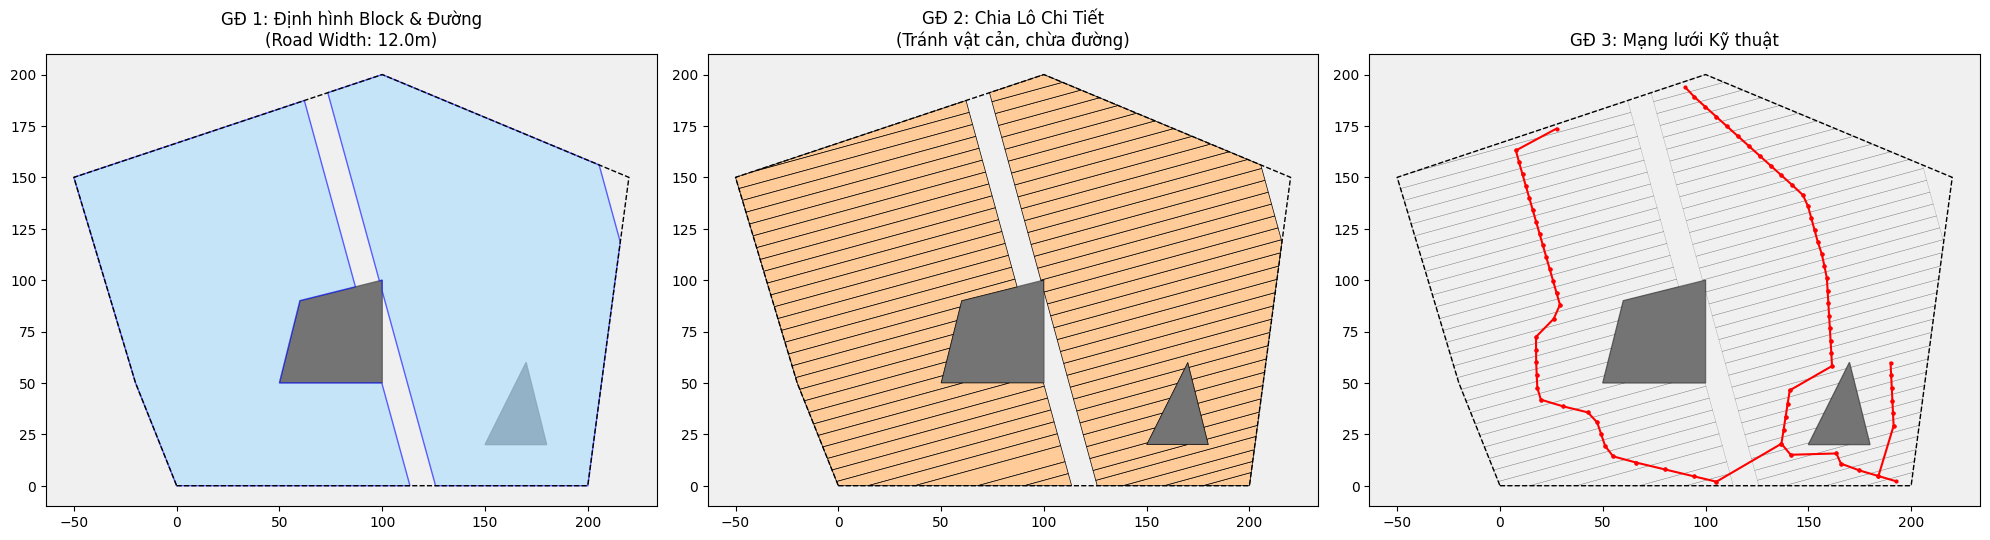

In [6]:
def plot_results_v2():
    fig, axs = plt.subplots(1, 3, figsize=FIG_SIZE)
    
    # Hàm vẽ nền (Đất gốc + Vật cản)
    def plot_background(ax):
        # Vẽ đất gốc
        ax.plot(*GLOBAL_LAND_POLY.exterior.xy, 'k--', linewidth=1, label='Ranh giới')
        # Vẽ vật cản
        for obs in GLOBAL_OBSTACLES:
            x, y = obs.exterior.xy
            ax.fill(x, y, color=COLOR_OBSTACLE, alpha=0.8, label='Vật cản')
        ax.set_facecolor(COLOR_LAND)

    # --- Plot 1: Macro Planning (DEAP) ---
    plot_background(axs[0])
    axs[0].set_title(f"GĐ 1: Định hình Block & Đường\n(Road Width: {ROAD_WIDTH}m)")
    for block in best_blocks_stage_1:
        x, y = block.exterior.xy
        axs[0].fill(x, y, fc=COLOR_BLOCK, ec='blue', alpha=0.6)
    axs[0].set_aspect('equal')

    # --- Plot 2: Micro Planning (OR-Tools) ---
    plot_background(axs[1])
    axs[1].set_title("GĐ 2: Chia Lô Chi Tiết\n(Tránh vật cản, chừa đường)")
    for lot in final_lots:
        x, y = lot.exterior.xy
        axs[1].fill(x, y, fc=COLOR_LOT, ec='black', linewidth=0.5)
    axs[1].set_aspect('equal')

    # --- Plot 3: Infrastructure ---
    plot_background(axs[2])
    axs[2].set_title("GĐ 3: Mạng lưới Kỹ thuật")
    for lot in final_lots:
        x, y = lot.exterior.xy
        axs[2].plot(x, y, 'k-', linewidth=0.3, alpha=0.3)
    
    # Vẽ đường dây hạ tầng
    for line in infra_lines:
        x, y = line.xy
        axs[2].plot(x, y, color='red', linewidth=1.5, marker='.', markersize=4)
        
    axs[2].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

plot_results_v2()

In [9]:
pip install shapely matplotlib networkx ortools scikit-learn scipy numpy

  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/07/c7/d64168da60332c17d24c0d2f08bdf3987e8d1ae9d84b5bbd0eec2eb26a55/networkx-3.6-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/18/d6/ba863a4171ac9d7314c4d3fc251f015704a2caeee41ced89f321c049ed83/scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/1e/e8/685f47e0d754320684db4425a0967f7d3fa70126bffd76110b7009a0090f/joblib-1.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00a 0:00:01

In [11]:
# ==========================================
# 0. IMPORTS
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon, LineString, MultiLineString
from shapely.ops import unary_union, voronoi_diagram
from shapely import affinity
import networkx as nx
from ortools.sat.python import cp_model
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
import random
import math

# ==========================================
# 1. CẤU HÌNH TIÊU CHUẨN KCN (PRODUCTION CONFIG)
# ==========================================

# --- A. Giao thông & Quy hoạch ---
ROAD_MAIN_WIDTH = 30.0      # Đường trục chính (m) - Xe container tránh nhau thoải mái
ROAD_INTERNAL_WIDTH = 15.0  # Đường nội bộ (m)
SIDEWALK_WIDTH = 4.0        # Vỉa hè mỗi bên (m) - Chứa hào kỹ thuật
TURNING_RADIUS = 15.0       # Bán kính cua xe Container (m) - Vạt góc ngã tư

# --- B. Đất đai & Phân khu chức năng ---
SERVICE_AREA_RATIO = 0.10   # 10% đất dành cho Hạ tầng (Nhà điều hành, XLNT, bãi xe)
MIN_BLOCK_AREA = 5000       # Diện tích block tối thiểu để chia lô (m2)

# --- C. Pháp lý & Xây dựng (TCVN) ---
SETBACK_DISTANCE = 6.0      # Chỉ giới xây dựng lùi vào so với chỉ giới đường đỏ (m)
FIRE_SAFETY_GAP = 4.0       # Khoảng cách PCCC giữa các nhà xưởng (nếu cần)

# --- D. Chia lô (OR-Tools) ---
MIN_LOT_WIDTH = 20.0        # Mặt tiền tối thiểu lô công nghiệp
MAX_LOT_WIDTH = 80.0
TARGET_LOT_WIDTH = 40.0
SOLVER_TIME_LIMIT = 0.5     # [QUAN TRỌNG] Giới hạn 0.5s mỗi block để tránh treo máy

# --- E. Hạ tầng kỹ thuật ---
TRANSFORMER_RADIUS = 300    # Bán kính phục vụ hiệu quả của 1 trạm biến áp (m)

Diện tích khu đất: 70.66 ha


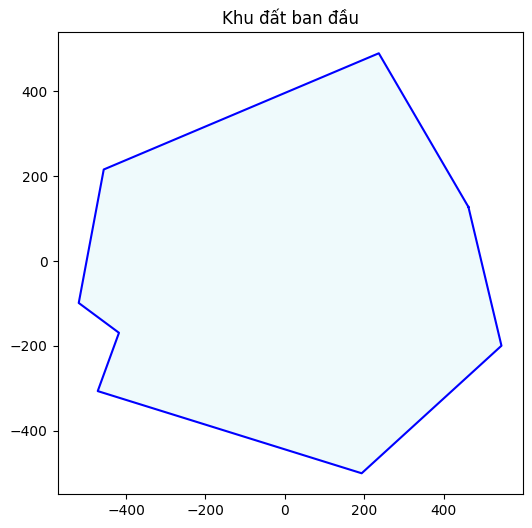

In [12]:
def create_random_site():
    # Tạo một đa giác ngẫu nhiên đại diện cho KCN (~50 ha)
    angles = np.sort(np.random.rand(8) * 2 * np.pi)
    radii = 400 + np.random.rand(8) * 200
    points = np.c_[radii * np.cos(angles), radii * np.sin(angles)]
    site = Polygon(points)
    return site

def get_elevation(x, y):
    # Hàm giả lập địa hình: Nghiêng từ Tây Bắc xuống Đông Nam
    # z = 100 - 0.05x - 0.03y (ví dụ)
    return 50.0 - (x * 0.02) - (y * 0.03)

# Khởi tạo
site_polygon = create_random_site()
minx, miny, maxx, maxy = site_polygon.bounds
print(f"Diện tích khu đất: {site_polygon.area / 10000:.2f} ha")

# Plot khu đất gốc
fig, ax = plt.subplots(figsize=(6, 6))
x, y = site_polygon.exterior.xy
ax.fill(x, y, color='#e0f7fa', alpha=0.5, label='Ranh giới KCN')
ax.plot(x, y, color='blue')
ax.set_title("Khu đất ban đầu")
plt.show()

In [14]:
# ==========================================
# 3. GIAI ĐOẠN 1: QUY HOẠCH GIAO THÔNG & PHÂN KHU
# ==========================================
from shapely.geometry import GeometryCollection

def generate_road_network(site, num_seeds=15):
    # 1. Tạo hạt Voronoi để chia mạng lưới đường
    minx, miny, maxx, maxy = site.bounds
    seeds = []
    for _ in range(num_seeds):
        seeds.append(Point(random.uniform(minx, maxx), random.uniform(miny, maxy)))
    
    # Tạo Voronoi Diagram
    # buffer(100) để đảm bảo các điểm nằm trong vùng tính toán
    regions = voronoi_diagram(MultiPolygon([site.buffer(100)]), envelope=site.buffer(200))
    
    # 2. Lấy cạnh của Voronoi làm tim đường
    edges = []
    
    # --- [FIX LỖI HERE] Xử lý GeometryCollection / MultiPolygon ---
    if hasattr(regions, 'geoms'):
        # Nếu là tập hợp (Collection), lặp qua .geoms
        for region in regions.geoms:
            if region.geom_type == 'Polygon':
                edges.append(region.exterior)
    elif regions.geom_type == 'Polygon':
        # Nếu chỉ có 1 Polygon duy nhất
        edges.append(regions.exterior)
            
    # Phân loại đường: Trục chính vs Nội bộ
    center = site.centroid
    road_polys = []
    
    # Hack nhẹ: Union các lines lại để xử lý chung
    all_lines = []
    for geom in edges:
        all_lines.append(geom)
        
    merged_lines = unary_union(all_lines)
    
    # Chuẩn hóa thành list các LineString đơn lẻ để duyệt
    lines_to_process = []
    if hasattr(merged_lines, 'geoms'):
        lines_to_process = list(merged_lines.geoms)
    else:
        lines_to_process = [merged_lines]
        
    for line in lines_to_process:
        if not isinstance(line, (LineString, MultiLineString)): 
            continue
            
        # Heuristic: Nếu đường đi qua gần tâm hoặc rất dài -> Trục chính
        dist_to_center = line.distance(center)
        if dist_to_center < 100 or line.length > 400:
            # Trục chính: Rộng + Vỉa hè
            width = ROAD_MAIN_WIDTH + 2 * SIDEWALK_WIDTH
            road_polys.append(line.buffer(width / 2, cap_style=2, join_style=2))
        else:
            # Nội bộ: Hẹp hơn
            width = ROAD_INTERNAL_WIDTH + 2 * SIDEWALK_WIDTH
            road_polys.append(line.buffer(width / 2, cap_style=2, join_style=2))
            
    # Hợp nhất mạng lưới đường thành 1 khối polygon
    if not road_polys:
        # Trường hợp hiếm không tạo được đường nào -> trả về danh sách rỗng để tránh lỗi
        return [], [], Polygon()
        
    network_poly = unary_union(road_polys)
    
    # 3. Xử lý Vạt góc (Turning Radius) tại ngã tư
    # Kỹ thuật: Buffer dương rồi buffer âm (Rounding corners) hoặc ngược lại
    # Ở đây dùng buffer dương (đã làm ở bước trên) -> buffer âm một chút để làm mượt nếu cần, 
    # hoặc dùng kỹ thuật buffer(R).buffer(-R) để bo tròn góc nhọn giao nhau.
    smooth_network = network_poly.buffer(TURNING_RADIUS, join_style=1).buffer(-TURNING_RADIUS, join_style=1)
    
    # Cắt đất thành các Block (Lấy đất gốc trừ đi đường)
    blocks_rough = site.difference(smooth_network)
    
    service_blocks = []
    commercial_blocks = []
    
    # Chuẩn hóa danh sách block candidates
    candidates = []
    if hasattr(blocks_rough, 'geoms'):
        candidates = list(blocks_rough.geoms)
    elif blocks_rough.geom_type == 'Polygon':
        candidates = [blocks_rough]
        
    # 4. Phân loại đất (Dành đất cho Hạ tầng)
    # Sắp xếp block theo cao độ (thấp nhất ưu tiên làm XLNT)
    candidates.sort(key=lambda b: get_elevation(b.centroid.x, b.centroid.y))
    
    total_area = sum([b.area for b in candidates])
    current_service_area = 0
    
    # Block thấp nhất -> Trạm xử lý nước thải (WWTP)
    if candidates:
        wwtp = candidates.pop(0) 
        service_blocks.append({'geom': wwtp, 'type': 'XLNT (Thấp nhất)'})
        current_service_area += wwtp.area
    
    # Các block còn lại
    for b in candidates:
        # Nếu block quá nhỏ hoặc hình dáng méo mó hoặc cần thêm đất dịch vụ -> Dịch vụ
        # (Heuristic: diện tích < 1.5 lần min hoặc chưa đủ chỉ tiêu 10%)
        if (current_service_area < total_area * SERVICE_AREA_RATIO) or (b.area < MIN_BLOCK_AREA):
             service_blocks.append({'geom': b, 'type': 'Điều hành/Bãi xe'})
             current_service_area += b.area
        else:
            commercial_blocks.append(b)
            
    return commercial_blocks, service_blocks, smooth_network

# Chạy lại hàm
blocks, service_blocks, road_network = generate_road_network(site_polygon)
print(f"Số block thương phẩm: {len(blocks)}")
print(f"Số block hạ tầng: {len(service_blocks)}")

Số block thương phẩm: 11
Số block hạ tầng: 2


In [15]:
def solve_subdivision_with_timelimit(total_len, min_w, max_w, target_w):
    """Giải thuật toán chia lô với giới hạn thời gian"""
    model = cp_model.CpModel()
    max_lots = int(total_len // min_w) + 2
    
    widths = []
    is_active = []
    diffs = []

    for i in range(max_lots):
        w = model.NewIntVar(0, int(max_w * 10), f'w_{i}')
        active = model.NewBoolVar(f'active_{i}')
        
        model.Add(w >= int(min_w * 10)).OnlyEnforceIf(active)
        model.Add(w <= int(max_w * 10)).OnlyEnforceIf(active)
        model.Add(w == 0).OnlyEnforceIf(active.Not())
        
        # Cố gắng đạt kích thước Target
        diff = model.NewIntVar(0, int(max_w * 10), f'diff_{i}')
        model.Add(diff >= w - int(target_w * 10)).OnlyEnforceIf(active)
        model.Add(diff >= int(target_w * 10) - w).OnlyEnforceIf(active)
        model.Add(diff == 0).OnlyEnforceIf(active.Not())
        
        widths.append(w)
        is_active.append(active)
        diffs.append(diff)
        
    total_w_var = model.NewIntVar(0, int(total_len * 10), 'total_w')
    model.Add(total_w_var == sum(widths))
    
    # Maximize diện tích lấp đầy & Minimize độ lệch chuẩn
    model.Maximize(total_w_var * 100 - sum(diffs))
    
    solver = cp_model.CpSolver()
    # --- [TIME LIMIT FIX] ---
    solver.parameters.max_time_in_seconds = SOLVER_TIME_LIMIT 
    
    status = solver.Solve(model)
    
    results = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for i in range(max_lots):
            if solver.Value(is_active[i]):
                results.append(solver.Value(widths[i]) / 10.0)
    return results

def calculate_legal_params(lot_polygon):
    """Tính mật độ xây dựng & Chỉ giới"""
    # 1. Chỉ giới xây dựng (Setback)
    buildable_area = lot_polygon.buffer(-SETBACK_DISTANCE)
    
    if buildable_area.is_empty:
        return None, 0, 0
    
    # 2. Mật độ xây dựng (Quy chuẩn VN - Ví dụ đơn giản hóa)
    # Diện tích càng lớn, mật độ cho phép càng giảm
    area_m2 = lot_polygon.area
    if area_m2 < 3000: density = 0.70  # 70%
    elif area_m2 < 10000: density = 0.65 # 65%
    else: density = 0.60 # 60%
    
    max_build_area = area_m2 * density
    
    return buildable_area, density * 100, max_build_area

final_lots = []
buildable_footprints = []

print("Đang chia lô...")
for idx, block in enumerate(blocks):
    rect = block.minimum_rotated_rectangle
    x, y = rect.exterior.coords.xy
    edge_lengths = [Point(x[i], y[i]).distance(Point(x[i+1], y[i+1])) for i in range(4)]
    max_idx = np.argmax(edge_lengths)
    total_len = edge_lengths[max_idx]
    
    # Gọi Solver (Time limited)
    widths = solve_subdivision_with_timelimit(total_len, MIN_LOT_WIDTH, MAX_LOT_WIDTH, TARGET_LOT_WIDTH)
    
    # Cắt hình học (Logic vector như cũ)
    p0 = np.array([x[max_idx], y[max_idx]])
    p1 = np.array([x[(max_idx+1)%4], y[(max_idx+1)%4]])
    vec = p1 - p0
    vec_len = np.linalg.norm(vec)
    if vec_len == 0: continue
    unit_vec = vec / vec_len
    ortho = np.array([-unit_vec[1], unit_vec[0]])
    
    curr = 0
    for w in widths:
        start = p0 + unit_vec * curr
        end = p0 + unit_vec * (curr + w)
        cutter = Polygon([start - ortho*500, end - ortho*500, end + ortho*500, start + ortho*500])
        lot = block.intersection(cutter)
        
        if not lot.is_empty and lot.area > 500: # Lọc lô vụn
             if isinstance(lot, MultiPolygon):
                 for g in lot.geoms: final_lots.append(g)
             else:
                 final_lots.append(lot)
        curr += w

# Tính toán tham số pháp lý cho từng lô
processed_lots = []
for lot in final_lots:
    b_zone, density, max_area = calculate_legal_params(lot)
    if b_zone is not None:
        processed_lots.append({
            'geom': lot,
            'buildable': b_zone,
            'density': density,
            'max_area': max_area
        })

print(f"✅ Hoàn tất chia {len(processed_lots)} lô đất thương phẩm.")

Đang chia lô...
✅ Hoàn tất chia 87 lô đất thương phẩm.


In [17]:
# ==========================================
# 5. GIAI ĐOẠN 3: HỆ THỐNG KỸ THUẬT (ADVANCED INFRA)
# ==========================================

# --- A. MẠNG LƯỚI ĐIỆN MẠCH VÒNG (LOOP NETWORK) ---
def create_loop_network(lots):
    centroids = [l['geom'].centroid for l in lots]
    G = nx.Graph()
    
    # Thêm nodes
    for i, p in enumerate(centroids):
        G.add_node(i, pos=(p.x, p.y))
        
    # Thêm cạnh (dựa trên khoảng cách)
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = centroids[i].distance(centroids[j])
            if dist < 150: # Chỉ nối các lô gần nhau
                G.add_edge(i, j, weight=dist)
                
    # 1. Tạo MST (Cây - Minimum Spanning Tree)
    # Kiểm tra đồ thị có liên thông không, nếu không thì nối các cụm
    if not nx.is_connected(G):
        # Fallback đơn giản: nối tất cả vào node 0 (hoặc xử lý phức tạp hơn)
        # Ở đây ta bỏ qua các node cô lập để tránh lỗi MST
        components = list(nx.connected_components(G))
        largest_comp = max(components, key=len)
        subgraph = G.subgraph(largest_comp).copy()
        mst = nx.minimum_spanning_tree(subgraph)
    else:
        mst = nx.minimum_spanning_tree(G)
    
    # 2. Tạo Loop (Vòng): Thêm lại 15% số cạnh đã bị loại bỏ để tạo mạch vòng an toàn
    all_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    loop_graph = mst.copy()
    
    added_count = 0
    target_extra = int(len(lots) * 0.15) # Thêm 15% cạnh dư thừa
    
    for u, v, data in all_edges:
        if not loop_graph.has_edge(u, v):
            try:
                loop_graph.add_edge(u, v, weight=data['weight'])
                added_count += 1
                if added_count >= target_extra: break
            except:
                pass
            
    return loop_graph

# Kiểm tra nếu có lô đất thì mới chạy
if len(processed_lots) > 0:
    infra_graph = create_loop_network(processed_lots)
else:
    infra_graph = nx.Graph()

# --- B. CLUSTER TRẠM BIẾN ÁP (K-MEANS) ---
if len(processed_lots) > 0:
    lot_coords = np.array([[l['geom'].centroid.x, l['geom'].centroid.y] for l in processed_lots])
    # Ước tính số trạm: 1 trạm phục vụ ~15 lô hoặc bán kính 300m
    num_transformers = max(1, int(len(processed_lots) / 15))
    
    # KMeans cần ít nhất số sample bằng số cluster
    if len(processed_lots) < num_transformers:
        num_transformers = len(processed_lots)
        
    kmeans = KMeans(n_clusters=num_transformers, n_init=10).fit(lot_coords)
    transformer_locs = kmeans.cluster_centers_
else:
    transformer_locs = np.array([])

# --- C. THOÁT NƯỚC (GRAVITY FLOW) ---
# Tìm hướng dòng chảy từ mỗi lô về phía trạm XLNT
wwtp_loc = None
for s in service_blocks:
    if "XLNT" in s['type']:
        wwtp_loc = s['geom'].centroid
        break
if wwtp_loc is None: wwtp_loc = site_polygon.centroid # Fallback

flow_arrows = []
for lot in processed_lots:
    c = lot['geom'].centroid
    # Vector hướng về XLNT
    dx = wwtp_loc.x - c.x
    dy = wwtp_loc.y - c.y
    
    # [FIXED] Dùng **2 (bình phương) thay vì *2 (nhân 2)
    length = math.sqrt(dx**2 + dy**2)
    
    # Chuẩn hóa vector để vẽ mũi tên ngắn (dài 30m)
    if length > 0:
        flow_arrows.append((c.x, c.y, dx/length*30, dy/length*30))
        
print("✅ Hoàn tất tính toán hệ thống kỹ thuật (Điện, Nước).")

✅ Hoàn tất tính toán hệ thống kỹ thuật (Điện, Nước).


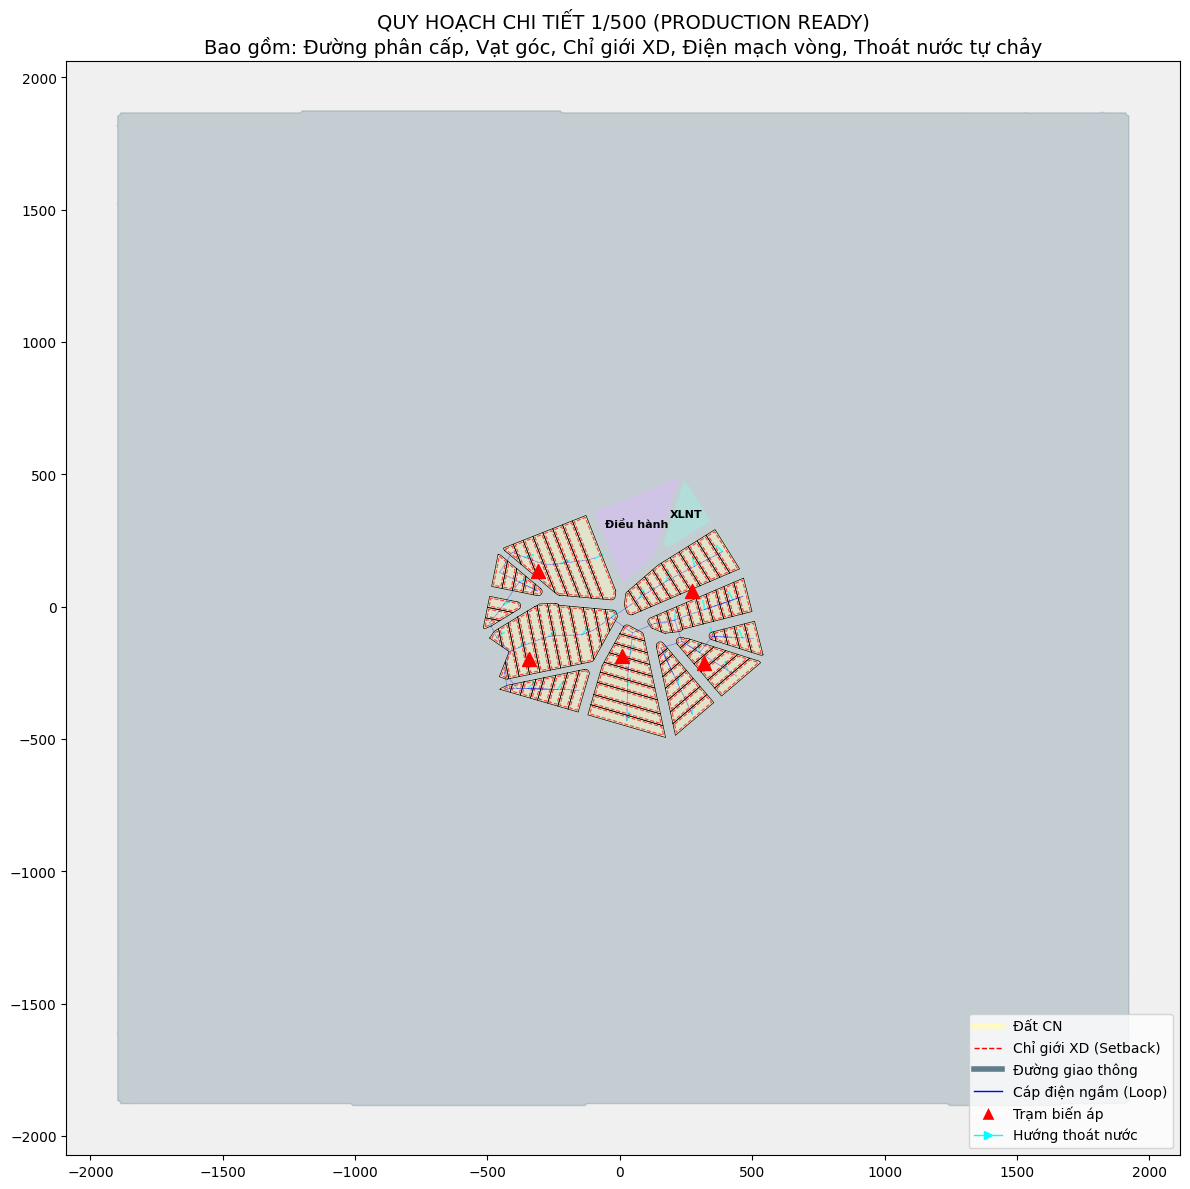

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal')
ax.set_facecolor('#f0f0f0')

# 1. Vẽ Đường & Vỉa hè
for geom in road_network.geoms if isinstance(road_network, MultiPolygon) else [road_network]:
    x, y = geom.exterior.xy
    ax.fill(x, y, color='#607d8b', alpha=0.3, label='Hạ tầng giao thông') # Đường xám

# 2. Vẽ Lô đất thương phẩm & Chỉ giới xây dựng
for lot in processed_lots:
    # Ranh giới lô đất
    x, y = lot['geom'].exterior.xy
    ax.plot(x, y, color='black', linewidth=0.5)
    ax.fill(x, y, color='#fff9c4', alpha=0.5) # Màu vàng đất CN
    
    # Chỉ giới xây dựng (Setback) - Nét đứt đỏ
    if not lot['buildable'].is_empty:
        if isinstance(lot['buildable'], Polygon):
            bx, by = lot['buildable'].exterior.xy
            ax.plot(bx, by, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
        elif isinstance(lot['buildable'], MultiPolygon):
             for b in lot['buildable'].geoms:
                bx, by = b.exterior.xy
                ax.plot(bx, by, color='red', linestyle='--', linewidth=0.8, alpha=0.7)

# 3. Vẽ Đất Dịch vụ / Kỹ thuật
for s in service_blocks:
    x, y = s['geom'].exterior.xy
    if "XLNT" in s['type']:
        color = '#b2dfdb' # Xanh nước
        label = "XLNT"
    else:
        color = '#d1c4e9' # Tím
        label = "Điều hành"
    ax.fill(x, y, color=color, alpha=0.9)
    ax.text(s['geom'].centroid.x, s['geom'].centroid.y, label, ha='center', fontsize=8, color='black', weight='bold')

# 4. Vẽ Hạ tầng điện (Mạch vòng)
pos = nx.get_node_attributes(infra_graph, 'pos')
# Vẽ cạnh (dây điện ngầm)
for u, v in infra_graph.edges():
    p1 = pos[u]
    p2 = pos[v]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue', linestyle='-', linewidth=0.5, alpha=0.4)

# 5. Vẽ Trạm biến áp (Cluster centers)
ax.scatter(transformer_locs[:, 0], transformer_locs[:, 1], c='red', marker='^', s=100, label='Trạm biến áp', zorder=10)

# 6. Vẽ Hướng thoát nước (Mũi tên) - Chỉ vẽ đại diện 1 số mũi tên cho đỡ rối
for i, (fx, fy, dx, dy) in enumerate(flow_arrows):
    if i % 3 == 0: # Lấy mẫu
        ax.arrow(fx, fy, dx, dy, head_width=5, head_length=5, fc='cyan', ec='cyan', alpha=0.6)

# Chú thích
plt.title("QUY HOẠCH CHI TIẾT 1/500 (PRODUCTION READY)\n"
          "Bao gồm: Đường phân cấp, Vạt góc, Chỉ giới XD, Điện mạch vòng, Thoát nước tự chảy", fontsize=14)

# Legend thủ công
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#fff9c4', lw=4),
                Line2D([0], [0], color='red', linestyle='--', lw=1),
                Line2D([0], [0], color='#607d8b', lw=4),
                Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10),
                Line2D([0], [0], color='cyan', lw=1, marker='>')]

ax.legend(custom_lines, ['Đất CN', 'Chỉ giới XD (Setback)', 'Đường giao thông', 'Cáp điện ngầm (Loop)', 'Trạm biến áp', 'Hướng thoát nước'], loc='lower right')

plt.tight_layout()
plt.show()